# TFIDF-Based Extractive Summarization: проведено сравнение метрик Rouge1 и RougeL на валидационной выборке для LEAD3 и TFIDF

In [ ]:
!pip install transformers sentence-transformers datasets rouge_score nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 38.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=a4420237808304a1cb5bc8535c7a2f0e2c8ea2fe86618f1b5e81a966f02020c6
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import nltk
import numpy as np
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Loading dataset multi_news

In [ ]:
import datasets
data = datasets.load_dataset("multi_news")
train_dataset, val_dataset = data['train'], data['validation']

SEMINAR_MODE = False
if SEMINAR_MODE:
  val_dataset = [val_dataset[i] for i in range(0, len(val_dataset), 5)] # list with each entry is a dictionary with keys "document" and "summary"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/44972 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5622 [00:00<?, ? examples/s]

In [ ]:
train_dataset["document"][0]

'National Archives \n \n Yes, it’s that time again, folks. It’s the first Friday of the month, when for one ever-so-brief moment the interests of Wall Street, Washington and Main Street are all aligned on one thing: Jobs. \n \n A fresh update on the U.S. employment situation for January hits the wires at 8:30 a.m. New York time offering one of the most important snapshots on how the economy fared during the previous month. Expectations are for 203,000 new jobs to be created, according to economists polled by Dow Jones Newswires, compared to 227,000 jobs added in February. The unemployment rate is expected to hold steady at 8.3%. \n \n Here at MarketBeat HQ, we’ll be offering color commentary before and after the data crosses the wires. Feel free to weigh-in yourself, via the comments section. And while you’re here, why don’t you sign up to follow us on Twitter. \n \n Enjoy the show. ||||| Employers pulled back sharply on hiring last month, a reminder that the U.S. economy may not be gr

In [ ]:
train_dataset["summary"][0]

'– The unemployment rate dropped to 8.2% last month, but the economy only added 120,000 jobs, when 203,000 new jobs had been predicted, according to today\'s jobs report. Reaction on the Wall Street Journal\'s MarketBeat Blog was swift: "Woah!!! Bad number." The unemployment rate, however, is better news; it had been expected to hold steady at 8.3%. But the AP notes that the dip is mostly due to more Americans giving up on seeking employment.'

In [ ]:
train_dataset[0]

{'document': 'National Archives \n \n Yes, it’s that time again, folks. It’s the first Friday of the month, when for one ever-so-brief moment the interests of Wall Street, Washington and Main Street are all aligned on one thing: Jobs. \n \n A fresh update on the U.S. employment situation for January hits the wires at 8:30 a.m. New York time offering one of the most important snapshots on how the economy fared during the previous month. Expectations are for 203,000 new jobs to be created, according to economists polled by Dow Jones Newswires, compared to 227,000 jobs added in February. The unemployment rate is expected to hold steady at 8.3%. \n \n Here at MarketBeat HQ, we’ll be offering color commentary before and after the data crosses the wires. Feel free to weigh-in yourself, via the comments section. And while you’re here, why don’t you sign up to follow us on Twitter. \n \n Enjoy the show. ||||| Employers pulled back sharply on hiring last month, a reminder that the U.S. economy 

In [ ]:
list(filter(len, ["a", "ab"]))

['a', 'ab']

In [ ]:
# exploring omne object (entry) in our dataset (several news sources + summary to them)
example = val_dataset[42]
#sources = tuple(filter(len, map(str.strip, example['document'].split('|||||'))))
sources = tuple(map(str.strip, example['document'].split('|||||')))
for i, source in enumerate(sources):
    print(f"SOURCE #{i}: {source}\n{'=' * 50}\n")
print("SUMMARY:\n", example['summary'])

SOURCE #0: A wonky beast about the size of a Labrador retriever with a long neck and lengthy tail may be the world's earliest known dinosaur, say researchers who analyzed fossilized bones discovered in Tanzania in the 1930s. 
 
 Now named Nyasasaurus parringtoni, the dinosaur would've walked a different Earth from today. It lived between 240 million and 245 million years ago when the planet's continents were still stitched together to form the landmass Pangaea. Tanzania would've been part of the southern end of Pangaea that also included Africa, South America, Antarctica and Australia. 
 
 It likely stood upright, measuring 7 to 10 feet (2 to 3 meters) in length, 3 feet (1 m) at the hip, and may have weighed between 45 and 135 pounds (20 to 60 kilograms). 
 
 "If the newly named Nyasasaurus parringtoni is not the earliest dinosaur, then it is the closest relative found so far," said lead researcher Sterling Nesbitt, a postdoctoral biology researcher at the University of Washington. 
 


In [ ]:
split_into_sentences  = nltk.sent_tokenize("I am a man. You are a women. She is a cat.")
split_into_sentences

['I am a man.', 'You are a women.', 'She is a cat.']

In [ ]:
split_into_words = list(map(nltk.word_tokenize, split_into_sentences))
split_into_words

[['I', 'am', 'a', 'man', '.'],
 ['You', 'are', 'a', 'women', '.'],
 ['She', 'is', 'a', 'cat', '.']]

# Functions to compute metrics Rouge 1  and Rouge L for algorithm comparison

In [ ]:
from rouge_score import rouge_scorer
from tqdm.auto import tqdm


scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score(target='The quick brown fox jumps over the lazy dog. ',
                      prediction='The quick brown dog jumps on the log.')
print(scores['rouge1'].fmeasure, scores['rougeL'].fmeasure)

0.7058823529411765 0.5882352941176471


In [ ]:
import pandas as pd
# in this dataframe we will store metrics for diffferent algorithms
metrics_stat = pd.DataFrame(index=["Rouge1", "RougeL"])
metrics_stat

""
Rouge1
RougeL


In [ ]:
from rouge_score import rouge_scorer
from tqdm import tqdm
def compute_rouge_f1(dataset, predictions):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    ############# <YOUR CODE: compute mean f-measures for Rouge-1 and Rouge-L>
    mean_r1, mean_rL = 0.0, 0.0
    for i, dic in enumerate(dataset):
      scores = scorer.score(dic["summary"], predictions[i])
      mean_r1 += scores['rouge1'].fmeasure
      mean_rL += scores['rougeL'].fmeasure
    # average measures over dataset
    mean_r1 /= len(dataset)
    mean_rL /= len(dataset)
    return mean_r1, mean_rL

# Functions to apply extractive summarizer

In [ ]:
def choose_summary_greedy(sentences, sentence_scores, sentence_similarities, sentence_lengths,
                          max_words=100, sim_threshold=0.9):
    """
    Greedy algorithm to choose the most relevant sentences up to max_words in total
    """
    assert sentence_scores.shape == (len(sentences),)
    chosen_sentences = []
    max_similarities = np.zeros(len(sentences))
    num_words = 0

    for i in range(len(sentences)):
        # masl basically filters similar sentences with respect to threshold
        mask = (sentence_lengths <= (max_words - num_words)) & (max_similarities < sim_threshold) # this line constraint us with number of words and also chosse the less similiar sentences based on threshold
        if not np.any(mask):
            break

        best_sentence_index = np.argmax(sentence_scores * mask) # from the least similar sentences according to threshold choose with maximum score (measure of importance of information)

        chosen_sentences.append(sentences[best_sentence_index])


        max_similarities = np.maximum(max_similarities, sentence_similarities[best_sentence_index])
        num_words += sentence_lengths[best_sentence_index]

    return chosen_sentences



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def summarize_one(documents : list, encoder, max_words = 100, sim_threshold=0.7):
    """
    Accepts list of documents to summirize and returns summary

    """
    #documents = tuple(filter(len, map(str.strip, document.split('|||||'))))

    sentences_by_doc = [nltk.sent_tokenize(doc) for doc in documents]
    sentences = [sent
                 for document in sentences_by_doc  # outer loop
                 for sent in document] #inner loop
    sentence_lengths = np.array([len(nltk.word_tokenize(sent)) for sent in sentences])

    # use encode_func to compute embedding matrices
    sentence_embeddings = encoder(sentences)

    # compute pairwise similarities between sentences and sentence-document pairs
    sentence_similarities = cosine_similarity(sentence_embeddings, sentence_embeddings)
    #document_similarities = <YOUR CODE HERE>


    # Setences  less similiar to other will have smaller average score over sosine_similarity matrix
    sentence_scores = sentence_similarities.mean(axis=-1)

    ######## Change for more interesting algo and results
    ######## [make dep inj or clone function to preserve results for comparison]
    summary_sentences = choose_summary_greedy(
        sentences, sentence_scores, sentence_similarities, sentence_lengths,
        max_words=max_words, sim_threshold=sim_threshold)

    return '\n'.join(summary_sentences)

In [ ]:
import re
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd


# Функция для предобработки текста
#nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    """
    Preprocess text before calculating TFIDF representation
    """
    # Приводим текст к нижнему регистру
    text = text.lower()

    # Удаляем никнеймы, хэштеги, URL-адреса и символы новой строки
    text = re.sub(r'@\w+|#[\w-]+|http\S+|\n', '', text)

    # Удаляем пунктуацию, не разделяя слова и знаки препинания
    text = re.sub(r'[^\w\s]', '', text)

    # Токенизируем текст для более точного разделения на слова
    #words = nlp(text, ) # TAKES  A LOT OF TIME

    # Фильтрация слов, состоящих только из подчеркиваний
    #processed_words = [word.lemma_ for word in words if not re.match(r'^_+$', word.lemma_)]

    # Соединяем обработанные слова в строку
    return text
def tfidf_encoder(documents):
    """
    returns encoder functor, recieves documents as list of strings
    """
    #vectorizer = TfidfVectorizer(preprocessor = preprocess_text, stop_words = "english")
    vectorizer = TfidfVectorizer(preprocessor = preprocess_text, stop_words = "english")
    vectorizer.fit(documents) # document is a collection of news on the same topic which has only one summary
    encode_func = lambda texts: vectorizer.transform(texts).toarray() # get embeddings for a word/sentence
    #tfidf_tokens = vectorizer.get_feature_names_out()
    #print(f"The dimensionality of embedding's space: {len(tfidf_tokens) }")
    return encode_func

# Baseline is 100 first words (LEAD 3 sentences approach) in each news artickle (applied to test set as there is no learning at all)

In [ ]:
# base line solution is the first 100 words of an artickle
MAX_WORDS = 100

def summarize_baseline(doc: str, max_words=MAX_WORDS):
    sentences = nltk.sent_tokenize('\n'.join(doc.split('|||||')))
    summary = []
    num_words = 0

    for sent in sentences:
        sentence_length = len(nltk.word_tokenize(sent, ))
        if num_words + sentence_length > max_words:
            break
        num_words += sentence_length
        summary.append(sent)
    return ' '.join(summary)

In [ ]:
print(summarize_baseline(val_dataset[42]['document']))

A wonky beast about the size of a Labrador retriever with a long neck and lengthy tail may be the world's earliest known dinosaur, say researchers who analyzed fossilized bones discovered in Tanzania in the 1930s. Now named Nyasasaurus parringtoni, the dinosaur would've walked a different Earth from today. It lived between 240 million and 245 million years ago when the planet's continents were still stitched together to form the landmass Pangaea.


In [ ]:
baseline_predictions = [summarize_baseline(row['document']) for row in val_dataset]
baseline_rouge1, baseline_rougeL = compute_rouge_f1(val_dataset, baseline_predictions)

print("Rouge-1:", baseline_rouge1)
print("Rouge-L:", baseline_rougeL)

if SEMINAR_MODE:
    assert abs(baseline_rouge1 - 0.26632) < 1e-4 and abs(baseline_rougeL - 0.14617) < 1e-4
    print("Well done!")

Rouge-1: 0.2695998278715543
Rouge-L: 0.14754643991569294


In [ ]:
metrics_stat["LEAD3"] = [baseline_rouge1, baseline_rougeL]
metrics_stat.head()

,LEAD3
Rouge1,0.269600
RougeL,0.147546


# TFIDF in sklearn overview, how to get TFIDF embedding for word/sentence

In [ ]:
import re
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# example of working with TFIDF from sklearn
corpus = ["He %is a pRofessor |||", "She is a      doCtor__", " Cats cannot be ---doctors or -professors"] # 3 docs in corpus (which just sentences in our case)



vectorizer = TfidfVectorizer(preprocessor = preprocess_text, stop_words = "english")
vectorizer.fit(corpus)
tfidf_tokens = vectorizer.get_feature_names_out()
X = vectorizer.transform(corpus)  # 3 documents and 3 words (so the TFIDF matrix is 3x3)

result = pd.DataFrame(
    data=X.toarray(),
    index=["Doc1", "Doc2", "Doc3"],
    columns=tfidf_tokens
)

result # TFIDF matrix for each word in each document


,cats,doctor__,doctors,professor,professors
Doc1,0.00000,0.0,0.00000,1.0,0.00000
Doc2,0.00000,1.0,0.00000,0.0,0.00000
Doc3,0.57735,0.0,0.57735,0.0,0.57735


In [ ]:
# We can get an embedding of any word or sentence apllying what we have learned on the whole corpus
s1 = ["Dogs don't __like ||| cats who___ work as professors" ]

vectorizer.transform(s1).toarray() # embedding for the sentence

array([[0.79596054, 0.        , 0.60534851]])

### Test pipeline on one example deom dataset

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# "train" TFIDF vectorizer to get embeddings on all the documents
example = val_dataset[2]
documents = list(filter(len, map(str.strip, example['document'].split('|||||'))))
encode_func = tfidf_encoder(documents) # returns encoder function

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make', 'whereaft'] not in stop_words.
  warnings.warn(


The dimensionality of embedding's space: 576


In [ ]:
x = encode_func(documents)
result = pd.DataFrame(
    data=x,
    columns=tfidf_tokens
)
result.head() # TFIDF for 2 news artickle

,0830,0845,1000,1030,11,1100,12,1215,15,1600,...,worship,wound,wroughton,yara,year,yemen,yemeni,yield,youtube,zawahris
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.035164,0.035164,0.035164,0.025019,0.200154,0.105491,0.000000,0.035164,0.035164
1,0.037089,0.037089,0.018545,0.055634,0.037089,0.018545,0.018545,0.018545,0.037089,0.018545,...,0.018545,0.000000,0.000000,0.000000,0.013195,0.026389,0.000000,0.018545,0.000000,0.000000


In [ ]:
sentences_by_doc = [nltk.sent_tokenize(doc) for doc in documents]
sentences = [sent
             for document in sentences_by_doc
             for sent in document] # nested loop, doucument is an iterator for the inner loop
sentence_lengths = np.array([len(nltk.word_tokenize(sent)) for sent in sentences])

sentence_embeddings = encode_func(sentences)
document_embeddings = encode_func(list(map('\n'.join, sentences_by_doc)))
print("Sentence embeddings shape:", sentence_embeddings.shape)
print("Document embedding shape:", document_embeddings.shape)

Sentence embeddings shape: (92, 576)
Document embedding shape: (2, 576)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# Compute cosine similarities between each pair of sentences
sentence_similarities = cosine_similarity(sentence_embeddings, sentence_embeddings)

# ... and also between each sentence and each document
document_similarities = cosine_similarity(sentence_embeddings, document_embeddings)

assert sentence_similarities.shape == (len(sentences), len(sentences))
assert document_similarities.shape == (len(sentences), len(documents))

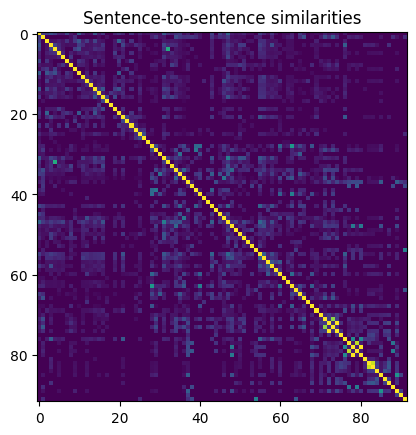

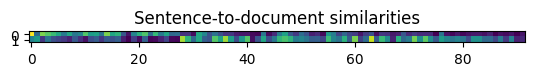

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("Sentence-to-sentence similarities")
plt.imshow(sentence_similarities)
plt.show()
plt.title("Sentence-to-document similarities")
plt.imshow(document_similarities.T)
plt.show()

In [ ]:
# target summary (writen by a human)
example["summary"]

'– Yemen-based al-Qaeda in the Arabian Peninsula has claimed responsibility for the Charlie Hebdo attack in an online video called "Vengeance for the Prophet: A Message Regarding the Blessed Battle of Paris," the New York Times reports. The group says it "chose the target, laid the plan, and financed the operation" in "a vengeance for the messenger of Allah"—a likely reference to Charlie Hebdo\'s parodies of the Prophet Muhammad. But while AQAP called the Kouachi brothers "two heroes of Islam," it suggests it wasn\'t behind the attacks that followed, including on a kosher supermarket. Gunman Amedy Coulibaly\'s actions were a coincidence, the statement says, calling him simply a "mujahid brother." The Charlie Hebdo attackers claimed to be working for AQAP, while Coulibaly has pledged support for ISIS, the BBC notes. The statement, made by AQAP leader Nasser bin Ali al-Ansi, says the attack was an "implementation" of orders from Ayman al-Zawahiri, the leader of the larger al-Qaeda group,

In [ ]:
# extracted summary
print(summarize_one(documents, encode_func))

Meanwhile, a new video apparently from AQAP said the group had planned and financed the Charlie Hebdo attacks in "vengeance for the Prophet".
Coulibaly had pledged allegiance to IS in a video message while the Charlie Hebdo attackers, Said and Cherif Kouachi, had said they were acting on behalf of AQAP.
The gunmen are said to have used earlier publication of images of the Prophet as justification for their attack on the magazine.
A video purportedly from al-Qaeda in Yemen said it planned the Hebdo attack.
Three days of terror


# Apply TFIDF-Based Extractive Summarization on validation dataset of Multi-News
![](https://i.imgur.com/kkrzeq7.png)

In [ ]:
from tqdm import trangle
our_summaries = []
for i in trange(len(val_dataset)):
    our_summaries.append(summarize_one(val_dataset[i]['document']))

In [ ]:
our_rouge1, our_rougel = compute_rouge_f1(val_dataset, our_summaries)

print("Rouge-1:", our_rouge1)
print("Rouge-L:", our_rougel)

In [ ]:
# compute rouge1 and rougeL on val dataset
#tfidf_predictions = [tfidf_encoder(row['document']) for row in val_dataset]
tfidf_predictions = []
for entry in tqdm(val_dataset):
  docs = list(filter(len, map(str.strip, entry['document'].split('|||||'))))
  try:
    enc = tfidf_encoder(docs)
  except ValueError:
    tfidf_predictions.append(" ")
    continue
  tfidf_predictions.append(summarize_one(docs, enc))

100%|██████████| 5622/5622 [05:48<00:00, 16.14it/s]


In [ ]:
tfidf_rouge1, tfidf_rougeL = compute_rouge_f1(val_dataset, tfidf_predictions)

In [ ]:
metrics_stat["TFIDF"] = [tfidf_rouge1, tfidf_rougeL]
metrics_stat.head()

,LEAD3,TFIDF
Rouge1,0.269600,0.310163
RougeL,0.147546,0.162592


In [ ]:
metrics_stat.to_pickle("metrics_stats")

# Compare LEAD3 with TFIDF-based extractive summarization

In [ ]:
metrics_stat.reset_index(inplace=True)
metrics_stat.rename(columns = {"index": "metric"}, inplace = True)
metrics_stat.head()

In [ ]:
metrics_stat.drop("level_0", axis = 1)

,metric,LEAD3,TFIDF
0,Rouge1,0.269600,0.310163
1,RougeL,0.147546,0.162592
